# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

## Data

In [128]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import time

Install library for processing the labeling
```bash
pip install xmltodict
```

In [129]:
import xmltodict, json

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [7]:
class2tag = {"apple": 53, "orange": 55, "banana": 52}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None, classification=True):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                if classification:
                    labels.append(class2tag[obj["name"]])
                else:
                    labels.append(1)
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(self.images[i])
            bboxes=self.annotations[i]["boxes"]
            labels=self.annotations[i]["labels"]
            
            return res, {
                "boxes": torch.tensor(bboxes),
                "labels": torch.tensor(labels),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

<br>  
<br>  
Функции для вычисления mAP.

In [76]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    
#     for i, el in enumerate(dt_labels):
#         if el == 55 or el == 52 or el == 53:
#             dt_labels[i] = 1
#         if el == 1:
#             dt_labels[i] = 92
        
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [11]:
import copy
def draw_bboxes(image, prediction, confidence=0.5):
    bboxes = prediction[0]['boxes']
    scores = prediction[0]['scores']
    img = copy.deepcopy(image)
    img = img[0].permute(1, 2, 0)
    img = torch.mul(img, 255)
    img = img.type(torch.uint8).cpu().numpy().copy()
    #print(img)
    for i, box in enumerate(bboxes):
        if scores[i]>confidence:
            b = [int(x.item()) for x in box]
            cv2.rectangle(img, b[:2], b[2:], (255,0,0), 2)
    plt.figure()
    plt.imshow(img)

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    if isinstance(data, dict):
        return dict((k, to_device(v, device)) for k, v in data.items())
    return data.to(device, non_blocking=True)

In [13]:
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    global_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = to_device(X, device), to_device(y, device)
        
        # Compute prediction error
        loss = model(X,y)
        
        # Backpropagation
        optimizer.zero_grad()
        #print(loss)
        global_loss = sum([el for el in loss.values()])
        global_loss.backward()
        optimizer.step()
    print("AVG LOSS:", global_loss/size)
        #if batch % 100 == 0:
            #loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    global_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = to_device(X, device), to_device(y, device)
            loss = model(X)
            #test_scores_loss += loss['']
            #test_bbox_loss += loss['']
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(loss)
            for value in loss.values():
                global_loss+=value
    print(global_loss)
    #test_scores_loss /= num_batches
    #test_bbox_loss /= num_batchesg
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [261]:
def learning_cycle(epochs, model, optimizer, train_dataloader, test_dataloader, scheduler, enable_evaluate=True):
    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        starttm = time.time()
        train(train_dataloader, model,  optimizer)
        scheduler.step()
        #test(test_dataloader, model)
        if enable_evaluate:
            print("RP AUC:", evaluate(model, test_dataloader, device))
        endtm = time.time()
        print(f"Time: {(endtm - starttm):>0.3f}")

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

In [16]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float32)
    #torchvision.transforms.Lambda(lambda x : x / 255)
])

In [17]:
fd = FruitDataset("test/", classification=False, transform=transform)

In [18]:
def collate_fn(data):
    return tuple(zip(*data))

In [19]:
batch_size=1
test_dataloader = DataLoader(fd, batch_size=batch_size, collate_fn=collate_fn)
for batch, (X, y) in enumerate(test_dataloader):
    print(batch)
    #print(X)
    print(y)
    print("Shape of X [N, C, H, W]: ", X[0].shape)
    #print("Shape of y: ", y['boxes'].shape, y['boxes'].dtype)
    break

0
({'boxes': tensor([[174.,  20., 364., 199.]]), 'labels': tensor([1])},)
Shape of X [N, C, H, W]:  torch.Size([3, 254, 390])


### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

In [20]:
import torchvision.models as models

In [21]:
retina = models.detection.retinanet_resnet50_fpn(pretrained=True)

In [22]:
rcnn = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
rcnn = rcnn.to(device)

In [23]:
#evaluate(retina, test_dataloader, device)

In [24]:
retina.train()
for batch, (X, y) in enumerate(test_dataloader):
    pred = retina(X,y)
    #draw_bboxes(X,pred)
    print(pred)
    break

{'classification': tensor(2.3873, grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1154, grad_fn=<DivBackward0>)}


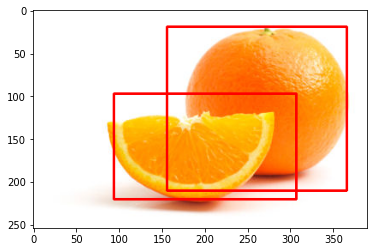

In [25]:
rcnn.eval()
for batch, (X, y) in enumerate(test_dataloader):
    X, y = to_device(X, device), to_device(y, device)
    pred = rcnn(X)
    draw_bboxes(X,pred)
    break

In [26]:
ssd = models.detection.ssd300_vgg16(pretrained=True)

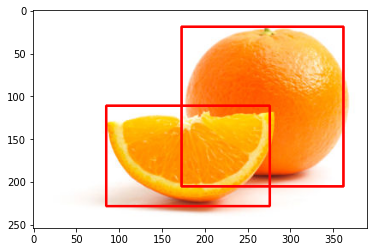

In [27]:
ssd.eval()
for batch, (X, y) in enumerate(test_dataloader):
    pred = ssd(X)
    draw_bboxes(X,pred)
    break

In [28]:
#evaluate(retina, test_dataloader, device)

In [29]:
fd[23][0].shape

torch.Size([3, 535, 800])

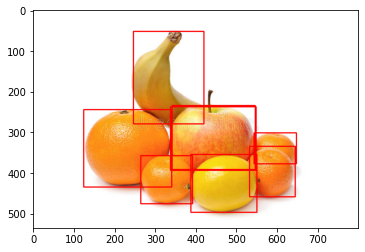

In [30]:
pred = rcnn(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred)

In [31]:
evaluate(rcnn, test_dataloader, device)

0.6714274818051309

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

In [32]:
rcnnf = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
rcnnf = rcnnf.to(device)

In [33]:
fd_train = FruitDataset("train/", classification=False, transform=transform)

In [34]:
from sklearn.model_selection import train_test_split
fd_train, fd_val = train_test_split(fd_train, test_size=0.2)

In [35]:
train_dataloader = DataLoader(fd_train, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(fd_val, batch_size=batch_size, collate_fn=collate_fn)

In [36]:
optimizer = torch.optim.SGD(rcnnf.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
learning_cycle(10, rcnnf, optimizer, train_dataloader, val_dataloader, scheduler)


Epoch 1
-------------------------------
AVG LOSS: tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 21.877

Epoch 2
-------------------------------
AVG LOSS: tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 20.819

Epoch 3
-------------------------------
AVG LOSS: tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 20.908

Epoch 4
-------------------------------
AVG LOSS: tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 20.972

Epoch 5
-------------------------------
AVG LOSS: tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 20.896

Epoch 6
-------------------------------
AVG LOSS: tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 20.935

Epoch 7
-------------------------------
AVG LOSS: tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.0
Time: 21.033

Epoch 8
-------------------------------
AVG LOSS: tensor(0.0025, device='cu

In [37]:
evaluate(rcnnf, test_dataloader, device)

0.0

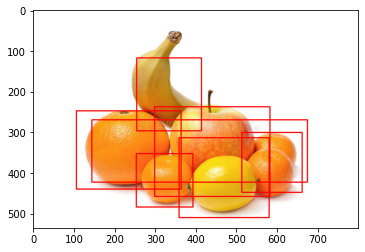

In [46]:
pred = rcnnf(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred)

In [77]:
def change_head_rcnn(model, num_classes):
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [78]:
rcnnf2 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
change_head_rcnn(rcnnf2, 2)
rcnnf2 = rcnnf2.to(device)

In [79]:
optimizer = torch.optim.SGD(rcnnf2.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
learning_cycle(10, rcnnf2, optimizer, train_dataloader, val_dataloader, scheduler)


Epoch 1
-------------------------------
AVG LOSS: tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.5352288381333167
Time: 23.228

Epoch 2
-------------------------------
AVG LOSS: tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.6265811950486844
Time: 22.812

Epoch 3
-------------------------------
AVG LOSS: tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.7674740314462026
Time: 23.111

Epoch 4
-------------------------------
AVG LOSS: tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.7570722601655283
Time: 23.241

Epoch 5
-------------------------------
AVG LOSS: tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.825430397377992
Time: 22.879

Epoch 6
-------------------------------
AVG LOSS: tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.8213378335753972
Time: 22.912

Epoch 7
-------------------------------
AVG LOSS: tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.83

In [80]:
evaluate(rcnnf2, test_dataloader, device)

0.8238528437364636

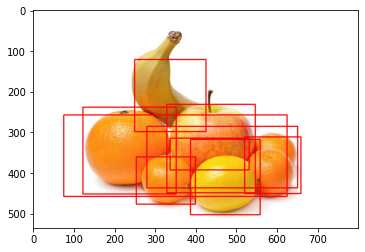

In [81]:
pred = rcnnf2(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred)

### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

при изменениии порога IoU значение метрики становится только меньше, потому что функция начинает отбрасывать некоторые баундинг боксы

в draw_bboxes порог для конфиденса уже добавлен. 

    при изменении значения порога конфиденса картинка получается более "чистой" (меньше ббоксов наложенных друг на друга)
    

но есть шанс потерять важные ббоксы, как мы в первом случае потеряли банан

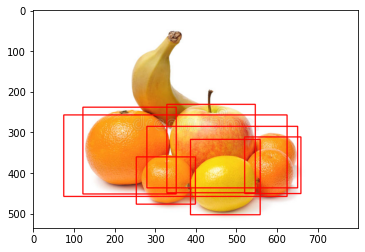

In [82]:
pred = rcnnf2(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred, confidence=0.8)

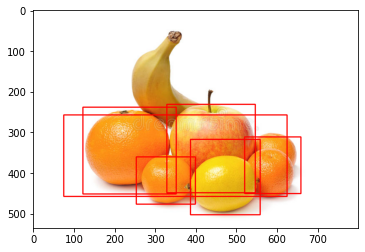

In [83]:
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred, confidence=0.9)

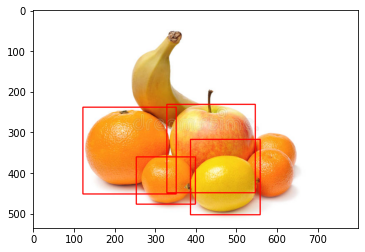

In [84]:
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred, confidence=0.95)

In [99]:
fd[17][0].shape

torch.Size([3, 676, 800])

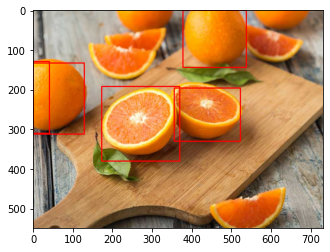

In [98]:
pred = rcnnf2(fd[3][0].reshape([1,3,549,732]).to(device))
draw_bboxes(fd[3][0].reshape([1,3,549,732]),pred, confidence=0.29)

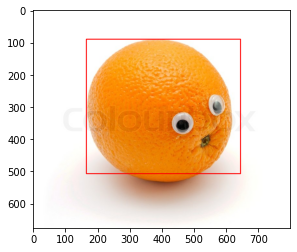

In [103]:
pred = rcnnf2(fd[17][0].reshape([1,3,676,800]).to(device))
draw_bboxes(fd[17][0].reshape([1,3,676,800]),pred, confidence=0.9)

обьекты на белом фоне мы оперделяем довольно неплохо

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

ща нарисую для картинок из интернета=)

In [ ]:
#cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB)

In [168]:
class CustomFruitDataset(Dataset):
    def __init__(self, data_dir, transform=None, classification=True):
        self.images = []
        self.transform = transform
        for root, currentDirectory, files in os.walk(data_dir):
            for image_fname in files:
                #print(cv2.imread(os.path.join(root, image_fname)))
                self.images.append(cv2.cvtColor(cv2.imread(os.path.join(root, image_fname)), cv2.COLOR_BGR2RGB))
            

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(self.images[i])
            return res
        else:
            return self.images[i]
        
    def __len__(self):
        return len(self.images)

In [169]:
fruits_and_dimon = CustomFruitDataset("custom_images/", classification=False, transform=transform)

In [176]:
fruits_and_dimon[1].shape

torch.Size([3, 343, 402])

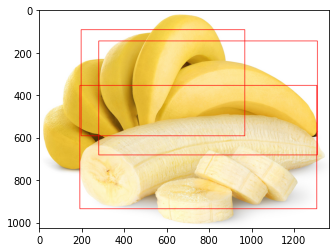

In [178]:
pred = rcnnf2(fruits_and_dimon[4].reshape([1,3,1025,1366]).to(device))
draw_bboxes(fruits_and_dimon[4].reshape([1,3,1025,1366]),pred, confidence=0.85)

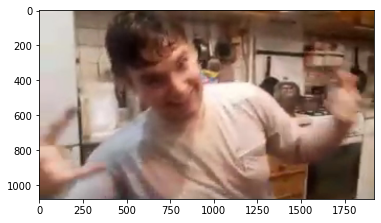

In [175]:
pred = rcnnf2(fruits_and_dimon[2].reshape([1,3,1080,1920]).to(device))
draw_bboxes(fruits_and_dimon[2].reshape([1,3,1080,1920]),pred, confidence=0.3)

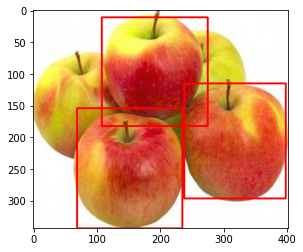

In [179]:
pred = rcnnf2(fruits_and_dimon[1].reshape([1,3,343,402]).to(device))
draw_bboxes(fruits_and_dimon[1].reshape([1,3,343,402]),pred, confidence=0.85)

яблочки вполне неплохо))

In [161]:
# test_dataloader = DataLoader(fruits_and_dimon, batch_size=batch_size, collate_fn=collate_fn)
# rcnnf2.eval()
# for batch, X in enumerate(test_dataloader):
#     #print(X.shape())
#     #break
#     X = to_device(X, device)
#     print(X)
#     pred = rcnnf2(torch.tensor(X))
#     draw_bboxes(X,pred,confidence=0.6)

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

In [210]:
def nms_pytorch(P : torch.tensor, S, thresh_iou : float):
    
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    scores = S

    areas = (x2 - x1) * (y2 - y1)
    
    order = scores.argsort()

    keep = []

    while len(order) > 0:
        
        idx = order[-1]

        keep.append(P[idx])

        order = order[:-1]

        if len(order) == 0:
            break
        
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        w = xx2 - xx1
        h = yy2 - yy1
        
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        inter = w*h

        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        union = (rem_areas - inter) + areas[idx]
        
        IoU = inter / union

        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep

In [252]:
def draw_bboxes_with_nms(image, prediction, confidence=0.3):
    bboxes = prediction[0]['boxes']
    scores = prediction[0]['scores']
    img = copy.deepcopy(image)
    img = img[0].permute(1, 2, 0)
    img = torch.mul(img, 255)
    img = img.type(torch.uint8).cpu().numpy().copy()
    keep = nms_pytorch(bboxes, scores, confidence)
    #print(keep)
    for i, box in enumerate(keep):
            b = [int(x.item()) for x in box]
            cv2.rectangle(img, b[:2], b[2:], (255,0,0), 2)
    plt.figure()
    plt.imshow(img)

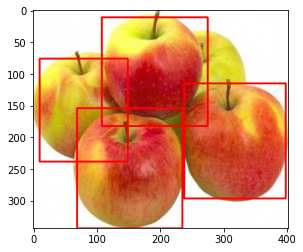

In [253]:
pred = rcnnf2(fruits_and_dimon[1].reshape([1,3,343,402]).to(device))
draw_bboxes_with_nms(fruits_and_dimon[1].reshape([1,3,343,402]), pred, confidence=0.2)

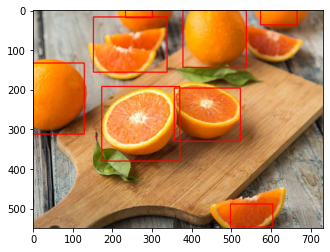

In [256]:
pred = rcnnf2(fd[3][0].reshape([1,3,549,732]).to(device))
draw_bboxes_with_nms(fd[3][0].reshape([1,3,549,732]),pred, confidence=0.05)

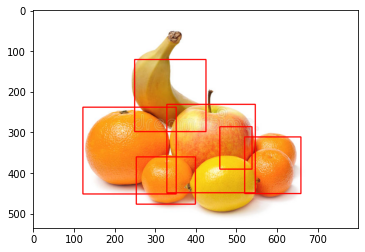

In [257]:
pred = rcnnf2(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes_with_nms(fd[23][0].reshape([1,3,535,800]),pred, confidence=0.19)

In [277]:
torch.save(rcnnf2.state_dict(), "my_models/82rcnnf2.pth")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### Часть 2.¶
Вес в общей оценке - 0.4

Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

In [181]:
fd3 = FruitDataset("test/", transform=transform)

In [182]:
rcnn3 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
rcnn3 = rcnn3.to(device)

In [183]:
test_dataloader3 = DataLoader(fd3, batch_size=batch_size, collate_fn=collate_fn)

In [184]:
evaluate(rcnn3, test_dataloader3, device)

0.6710011402398298

In [186]:
fd_train3 = FruitDataset("train/", transform=transform)
fd_train3, fd_val3 = train_test_split(fd_train3, test_size=0.2)
train_dataloader3 = DataLoader(fd_train3, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader3 = DataLoader(fd_val3, batch_size=batch_size, collate_fn=collate_fn)

In [187]:
rcnnf3 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
rcnnf3 = rcnnf3.to(device)

In [188]:
optimizer = torch.optim.SGD(rcnnf3.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
learning_cycle(10, rcnnf3, optimizer, train_dataloader3, val_dataloader3, scheduler)


Epoch 1
-------------------------------
AVG LOSS: tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.2711410702950374
Time: 20.327

Epoch 2
-------------------------------
AVG LOSS: tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.6868595368342321
Time: 20.212

Epoch 3
-------------------------------
AVG LOSS: tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.7578217265128191
Time: 20.081

Epoch 4
-------------------------------
AVG LOSS: tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.7862677284982448
Time: 21.311

Epoch 5
-------------------------------
AVG LOSS: tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.8096506454106173
Time: 20.427

Epoch 6
-------------------------------
AVG LOSS: tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.8164619937577099
Time: 20.332

Epoch 7
-------------------------------
AVG LOSS: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.7

In [ ]:
learning_cycle(5, rcnnf3, optimizer, train_dataloader3, val_dataloader3, scheduler)

In [189]:
evaluate(rcnnf3, test_dataloader3, device)

0.7575822669864395

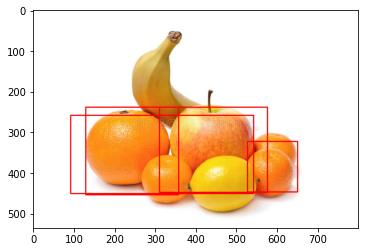

In [190]:
pred = rcnnf3(fd[23][0].reshape([1,3,535,800]).to(device))
draw_bboxes(fd[23][0].reshape([1,3,535,800]),pred, confidence=0.8)

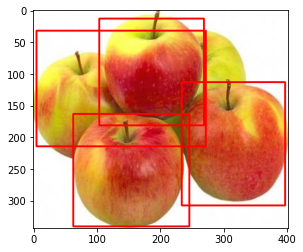

In [196]:
pred = rcnnf3(fruits_and_dimon[1].reshape([1,3,343,402]).to(device))
draw_bboxes(fruits_and_dimon[1].reshape([1,3,343,402]),pred, confidence=0.7)

In [201]:
fruits_and_dimon[3].shape

torch.Size([3, 500, 500])

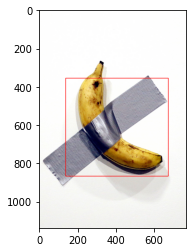

In [258]:
pred = rcnnf3(fruits_and_dimon[0].reshape([1,3,1137,768]).to(device))
draw_bboxes(fruits_and_dimon[0].reshape([1,3,1137,768]),pred, confidence=0.7)

банан задетектировался несмотря на изоленту=)))

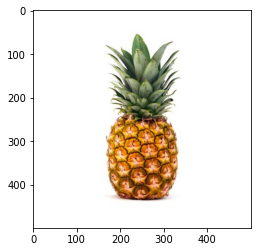

In [204]:
pred = rcnnf3(fruits_and_dimon[3].reshape([1,3,500,500]).to(device))
draw_bboxes(fruits_and_dimon[3].reshape([1,3,500,500]),pred, confidence=0.3)

Ананас не определяется даже с низким конфиденсом!!!

In [270]:
ssd = models.detection.ssd300_vgg16(pretrained=False)

In [240]:
retina = models.detection.retinanet_resnet50_fpn(pretrained=True)
retina = retina.to(device)

In [241]:
optimizer = torch.optim.SGD(retina.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
learning_cycle(10, retina, optimizer, train_dataloader3, val_dataloader3, scheduler)


Epoch 1
-------------------------------
AVG LOSS: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.8908645042633914
Time: 93.732

Epoch 2
-------------------------------
AVG LOSS: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9188212547942698
Time: 96.960

Epoch 3
-------------------------------
AVG LOSS: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9275174373683321
Time: 99.514

Epoch 4
-------------------------------
AVG LOSS: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9340023770122404
Time: 97.235

Epoch 5
-------------------------------
AVG LOSS: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9335480012699772
Time: 99.283

Epoch 6
-------------------------------
AVG LOSS: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9257413599287803
Time: 98.607

Epoch 7
-------------------------------
AVG LOSS: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
RP AUC: 0.9

In [242]:
evaluate(retina, test_dataloader3, device)

0.8696858046233901

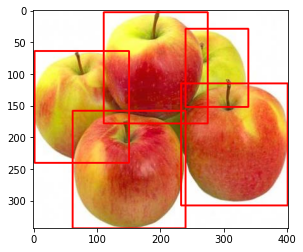

In [259]:
pred = retina(fruits_and_dimon[1].reshape([1,3,343,402]).to(device))
draw_bboxes_with_nms(fruits_and_dimon[1].reshape([1,3,343,402]),pred, confidence=0.3)

In [266]:
from torchvision.models.detection import _utils as det_utils

In [271]:
n_classes=4
num_anchors = ssd.anchor_generator.num_anchors_per_location()
out_channels = det_utils.retrieve_out_channels(ssd.backbone, (300, 300))
ssd.head.classification_head = models.detection.ssd.SSDClassificationHead(
                in_channels=out_channels,
                num_anchors=num_anchors,
                num_classes=n_classes,
            )

In [274]:
device

'cuda'

In [272]:
ssd = ssd.to(device)

In [275]:
optimizer = torch.optim.SGD(retina.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
learning_cycle(10, ssd, optimizer, train_dataloader3, val_dataloader3, scheduler)


Epoch 1
-------------------------------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

<br>  
<br>  
  
## Часть 3.  
  
*Вес в общей оценке - 0.2*  
  
Обучите модель для object detection для трех классов на __обучающем__ датасете и добейтесь PR AUC не менее __0.91__ на  __тестовом__.  
Баллы за задание вычисляются по формуле: __min(2, 2 * Ваш auc / 0.91)__.

<br>  
<br>  
  
## Бонусные задания.  
  
1. При обучении используйте аугментации (в первую очередь пространственные) из [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) или [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html).  
2. Возьмите одну из [детекционных архитектур](https://paperswithcode.com/sota/object-detection-on-coco) (желательно, не старее 2020 года), у которой выложены тренировочный код и чекпоинты на гитхабе, обучите и провалидируйте ее на данных этой лабораторной. 